Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379
    
Lesson 3 RNN


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string

In [3]:
# bs=48
# bs=24
bs=192

In [4]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
df = pd.read_csv('/home/trpb2/data/takeaway/takeaway_names.txt', header = None)

In [9]:
df['name'] = df.name.str.lower()

In [10]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
valid_df = df[~msk]

In [11]:
train_df

,name
1,squires restaurant
2,silver spoon kitchen
3,akwaahs kitchen
4,bronze restaurant
5,la bell cuisine
7,nikki's place
8,orchard
9,dixy chicken
10,divine flavouz african cuisine
12,flavorz


In [4]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [5]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'" +"0123456789")

In [6]:
itos

['xxunk',
 'xxbos',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ',
 '-',
 "'",
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [7]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [34]:
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=0, mark_fields=False, bs=128)

NameError: name 'train_df' is not defined

In [17]:
data.show_batch()

idx,text
0,s t a u r a n t xxbos l a b e l l c u i s i n e xxbos n i k k i ' s p l a c e xxbos o r c h a r d xxbos d i x y c h i c k e
1,i n o ' s 2 xxbos t h e o v a l l o u n g e xxbos m a r k e t c a f e s u n d a y d i n n e r d e l i v e r xxunk xxunk
2,g d r a g o n a c t o n xxbos w e s t v i e w c h i n e s e xxbos w i n g f u xxbos j a s m i n e g a r d e n xxbos n e
3,r a g o n - i xxbos n e w c h o p c h o p xxbos y u m m y c i t y xxbos t h e g r e a t w a l l xxbos h o w a h xxbos
4,s c o o k i n g xxbos y u m m y k i n g xxbos s i l v e r s e a c h i n e s e xxbos c a n t o n c h e f c h i n e s


In [20]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


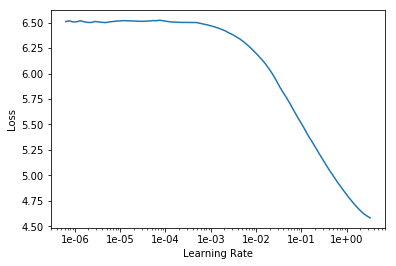

In [59]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.481068,1.909898,0.450105,00:10


In [22]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.231937,1.218382,0.631394,00:13
1,1.238995,1.223885,0.629097,00:13
2,1.219310,1.203504,0.635045,00:13
3,1.210485,1.208328,0.633810,00:13
4,1.178260,1.183156,0.641662,00:13
5,1.154104,1.175704,0.644551,00:13
6,1.133904,1.170966,0.645798,00:13
7,1.109461,1.167290,0.646882,00:13
8,1.102520,1.166125,0.647610,00:13
9,1.096980,1.166519,0.647564,00:13


In [33]:
TEXT = "meat"
N_WORDS = 40
N_SENTENCES = 10

In [34]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

meat s   e x p r e s s xxbos   p e t e r ' s   p i z z a xxbos   t h e   b a k e r y xxbos   w e
meat   w a n g xxbos   h a p p y   f o u r xxbos   y   e x p r e s s   t a k e a w a y xxbos   l
meat h e r s   r e s t a u r a n t xxbos   t h e   s a n d w i c h   c o   l t d xxbos   n o
meat s   p l a i c e xxbos   s p i c y   o f   t h e   c o t t a g e xxbos   w i n g s   c h
meat   s a n d w i c h   b a r xxbos   d e l i c i o u s   o f   i n d i a xxbos   b a l t i
meat   w a l l   c h i n e s e   t a k e a w a y xxbos   c a s p i a n   f i s h   b a r
meat   c h o i c e xxbos   f i s h   d e l i g h t s xxbos   b i r d   ' n '   s p i c e xxbos  
meat   c a n t o n e s e   t a k e a w a y xxbos   h i l l t o p   c h i p p y xxbos   s h a
meat   g o l d e n   p a l a c e   g r i l l xxbos   m i n i   f i s h   b a r xxbos   n e w
meat   t o w n   t a k e   a w a y xxbos   t h e   o l d   r o a d   f i s h   b a r xxbos  


In [35]:
learn.save('fine_tuned')

In [36]:
learn.save_encoder('fine_tuned_enc')

In [5]:
df = pd.read_csv('/rds/user/trpb2/hpc-work/data/takeaway/OS Data June 2019.txt', sep="|", encoding='latin-1')

/home/trpb2/.conda/envs/fastai_v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,14,15,16,22,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.columns

Index(['UNIQUE_REFERENCE_NUMBER', 'NAME', 'POINTX_CLASSIFICATION_CODE',
       'FEATURE_EASTING', 'FEATURE_NORTHING', 'POSITIONAL_ACCURACY_CODE',
       'UPRN', 'TOPOGRAPHIC_TOID', 'TOPOGRAPHIC_TOID_VERSION', 'ITN_EASTING',
       'ITN_NORTHING', 'ITN_TOID', 'ITN_TOID_VERSION', 'DISTANCE',
       'ADDRESS_DETAIL', 'STREET_NAME', 'LOCALITY', 'GEOGRAPHIC_COUNTY',
       'POSTCODE', 'VERIFIED_ADDRESS', 'ADMINISTRATIVE_BOUNDARY',
       'TELEPHONE_NUMBER', 'URL', 'BRAND', 'QUALIFIER_TYPE', 'QUALIFIER_DATA',
       'PROVENANCE', 'DATE_OF_SUPPLY'],
      dtype='object')

In [7]:
takeaway = ['1020018', '1020019', '1020020']
df_take = df.loc[df['POINTX_CLASSIFICATION_CODE'].isin(takeaway)].copy()

In [8]:
df_take.head

<bound method NDFrame.head of          UNIQUE_REFERENCE_NUMBER                     NAME  \
1491124                 47967722         Sandwich Express   
1493179                 47967403    McDonald's Restaurant   
1493409                 47967696            Sandwich Shop   
1493557                 47971419    McDonald's Restaurant   
1493558                 47971430    McDonald's Restaurant   
1493561                 47971907          Burger King Ltd   
1493562                 47971937    McDonald's Restaurant   
1493563                 47972171          Minnie Bertha's   
1493569                 47972563    McDonald's Restaurant   
1493570                 47972579          Burger King Ltd   
1493572                 47973740    McDonald's Restaurant   
1493573                 47974815    McDonald's Restaurant   
1493578                 47973069    McDonald's Restaurant   
1493579                 47973189          Burger King Ltd   
1493580                 47974285    McDonald's Restaura

In [10]:
df_take_trim = df_take[['NAME','POINTX_CLASSIFICATION_CODE']].copy()
df_take_trim.to_json(path_or_buf='/rds/user/trpb2/hpc-work/data/takeaway/OS_Data_June_2019_take_names.txt')

In [11]:
df_take_trim = pd.read_json(path_or_buf='/rds/user/trpb2/hpc-work/data/takeaway/OS_Data_June_2019_take_names.txt')

In [12]:
df_take_trim['NAME'] = df_take_trim.NAME.str.lower()

In [13]:
msk = np.random.rand(len(df_take_trim)) < 0.8
train_df = df_take_trim[msk]
valid_df = df_take_trim[~msk]

In [4]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [5]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'" +"0123456789")

In [6]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [17]:
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=0, mark_fields=False, bs=128)

In [18]:
data.show_batch()

idx,text
0,b u r g e r k i n g l t d xxbos m c d o n a l d ' s r e s t a u r a n t xxbos m i n n i e b e r t h a ' s xxbos m c d o
1,i m p y r e s t a u r a n t s g r o u p l t d xxbos p i z z a h o u s e xxbos c h a r l e s t o n c a f e xxbos g o o d
2,c h i p s xxbos r e g e n t s f i s h b a r xxbos m a c ' s f i s h b a r xxbos s u e ' s xxbos t h e m u n c h i e s xxbos
3,l xxbos g o l d e n f l a m e xxbos i n d i a h o u s e xxbos t o n g t o n g c h i n e s e t a k e a w a y xxbos t o w
4,g a r d e n xxbos c i t y c h i c k e n xxbos a l i ' s k e b a b xxunk c u r r y h o u s e xxbos w i s h b o n e p i z


In [19]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [20]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (49649 items)
x: LMTextList
xxbos   m c d o n a l d ' s   r e s t a u r a n t,xxbos   m c d o n a l d ' s   r e s t a u r a n t,xxbos   m c d o n a l d ' s   r e s t a u r a n t,xxbos   b u r g e r   k i n g   l t d,xxbos   m c d o n a l d ' s   r e s t a u r a n t
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (12577 items)
x: LMTextList
xxbos   s a n d w i c h   e x p r e s s,xxbos   s a n d w i c h   s h o p,xxbos   m c d o n a l d ' s   r e s t a u r a n t,xxbos   p i z z a   r o m a,xxbos   m o o r l a n d s   f a s t   f o o d
y: LMLabelList
,,,,
Path: .;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(41, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(41, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True

In [21]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


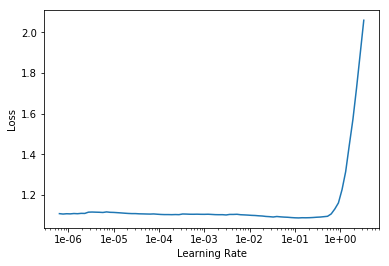

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.076117,0.971486,0.702159,00:14
1,1.061421,0.963648,0.704095,00:13
2,1.036790,0.961305,0.704702,00:13


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.017029,0.949426,0.708516,00:18
1,0.999909,0.941916,0.712267,00:18
2,0.980585,0.939665,0.712655,00:18
3,0.971151,0.934318,0.715096,00:18
4,0.946331,0.930109,0.716824,00:18
5,0.916333,0.924935,0.718697,00:18
6,0.911334,0.922325,0.719808,00:18
7,0.882628,0.920801,0.720463,00:18
8,0.873565,0.920930,0.720638,00:18
9,0.865203,0.920309,0.720613,00:18


In [27]:
TEXT = "curry"
N_WORDS = 100
N_SENTENCES = 50

In [28]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

curry   c o r n e r xxbos   r e a l   j u n c t i o n xxbos   s u b w a y xxbos   d u n g   h i n g xxbos   k   f   c   l t d xxbos   s u b w a y xxbos   m u n c h i e s xxbos   t h e   p i z z a   g o g o xxbos   p u n j a b i   d e l i
curry   h u t xxbos   h a p p y   h o u s e xxbos   d e l i   1 1 xxbos   s i l v e r   s t a r xxbos   m c d o n a l d ' s   r e s t a u r a n t xxbos   k   f   c   l t d xxbos   k e n s   k i t c h e n xxbos   f i v e   g u y s xxbos  
curry   h u t xxbos   s u p e r   f r y e r xxbos   t h e   g r e a t   w a l l xxbos   p i z z a   d e l i c i o u s xxbos   p i z z a   h u t xxbos   p i z z a   m a r i o xxbos   g o l d e n   b r i d g e xxbos   l i v o r s y   f
curry   m a h a l xxbos   p a p a   j o h n ' s   l t d xxbos   s u n f l o w e r xxbos   c h i n a   c h i n a xxbos   s p i c e   o f   i n d i a xxbos   p i z z a   h u t xxbos   s t a r   g r i l l xxbos   s u b w a y xxbos   n i c e
curry   h o u s e xxbos   p i z z a   h u t xxbos   

In [29]:
learn.save('fine_tuned_take')

In [30]:
learn.save_encoder('fine_tuned_take_enc')

In [7]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('/home/trpb2/data/takeaway/', 'just_eat_cleaned2.csv',
                         tokenizer=tokenizer, vocab=vocab, bs=256)

In [9]:
data_clas.show_batch()

text,target
g i l l s g o l d e n f i s h a n d c h i p s p i z z a k e b a b s a n d b u r g e r s,Fish and Chips
t u r k i s h k e b a b a n d m e d f i s h b a r a n d f r e s h f r i e d c h i c k e n,Fish and Chips
a p h r o d i t e xxunk s g r e e k m e d i t e r r a n e a n c u i s i n e a n d p i z z e r i a,Other
f l a v a z a u t h e n t i c c a r i b b e a n f o o d a n d e n g l i s h t a k e a w a y,Caribbean
g o l d e n g r i l l k e b a b p i z z a b u r g e r a n d f r i e d c h i c k e n,Kebab


In [27]:
# learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learn.load_encoder('fine_tuned_take_enc')
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=50)
learn.load_encoder('fine_tuned_take_enc')

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


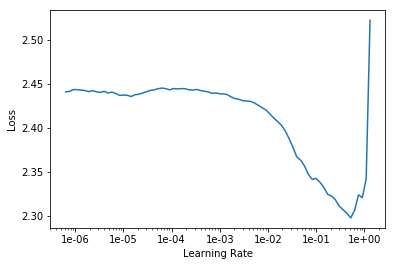

In [12]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10, 5e-2, moms=(0.5,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,2.033266,1.978429,0.274371,00:06
1,1.957308,2.079816,0.201296,00:06
2,1.965033,9.310196,0.193913,00:06
3,1.946947,1.944648,0.328914,00:06
4,1.943859,1.955984,0.285671,00:06
5,1.924727,1.903552,0.309929,00:07
6,1.892666,1.902773,0.294410,00:06
7,1.883779,1.849321,0.323942,00:06
8,1.884781,1.840299,0.330571,00:07
9,1.872872,1.794678,0.346994,00:06


In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, 1e-2, moms=(0.5,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,1.552507,1.683985,0.402742,00:14
1,1.291243,1.401439,0.562754,00:14
2,1.040915,0.932039,0.711014,00:14
3,0.941179,0.859158,0.731656,00:14
4,0.860922,0.805140,0.753352,00:14
5,0.766161,0.766477,0.765858,00:15
6,0.715259,0.748877,0.774296,00:15
7,0.649111,0.742894,0.780322,00:14
8,0.561426,0.756736,0.783486,00:14
9,0.534041,0.770164,0.782281,00:15


In [16]:
learn.fit_one_cycle(10, 1e-2, moms=(0.2,0.1))

epoch,train_loss,valid_loss,accuracy,time
0,0.525214,0.786186,0.777158,00:13
1,0.595883,0.792686,0.767666,00:14
2,0.698043,0.796735,0.756366,00:14
3,0.738910,0.786103,0.761941,00:13
4,0.723324,0.771238,0.770981,00:13
5,0.667660,0.750403,0.775953,00:13
6,0.636762,0.745331,0.781076,00:13
7,0.579327,0.752154,0.779117,00:14
8,0.507280,0.770408,0.778665,00:14
9,0.476563,0.780124,0.777610,00:14


In [25]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.404347,0.829010,0.765477,00:06
1,0.469652,0.843588,0.753410,00:07
2,0.566915,0.768581,0.775184,00:07
3,0.615458,0.779243,0.767051,00:07
4,0.623698,0.744845,0.772036,00:07
5,0.585304,0.777912,0.770986,00:07
6,0.537861,0.788623,0.775446,00:07
7,0.476540,0.804572,0.775971,00:07
8,0.418001,0.820105,0.775184,00:07
9,0.381202,0.829351,0.773610,00:06


In [26]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15243 items)
x: TextList
xxbos   h o n g   k o n g   t a k e a w a y,xxbos   g u r u   e x p r e s s,xxbos   l o t u s   c h i n e s e   t a k e a w a y,xxbos   c a k e a w a y   c e n t r a l   xxunk m a n c h e s t e r xxunk,xxbos   r o y a l   c h i c k e n   xxunk   p i z z a
y: CategoryList
Chinese,Indian,Chinese,Other,Chicken
Path: /home/trpb2/data/takeaway;

Valid: LabelList (3812 items)
x: TextList
xxbos   d i x y   c h i c k e n,xxbos   h o   l o k,xxbos   n e w   c h i n a   c h i n a,xxbos   c h i c k e n   c o t t a g e,xxbos   s p i c y   c h i c k e n
y: CategoryList
Chicken,Chinese,Chinese,Chicken,Chicken
Path: /home/trpb2/data/takeaway;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(41, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(41, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
 

In [37]:
learn.predict("ali")

(Category Indian,
 tensor(6),
 tensor([8.0158e-04, 1.8279e-04, 5.8076e-04, 3.0603e-05, 9.5918e-05, 1.8817e-04,
         9.2339e-01, 3.6895e-03, 2.4361e-02, 4.6622e-02, 5.7291e-05]))

In [44]:
learn.predict("fryer tuck")

(Category Fish and Chips,
 tensor(5),
 tensor([1.1382e-05, 9.5719e-05, 1.6008e-02, 6.0632e-03, 3.0964e-05, 9.3017e-01,
         1.4206e-03, 1.6480e-02, 6.8484e-03, 2.2800e-02, 7.6557e-05]))

In [42]:
learn.predict("pearl palace")

(Category Chinese,
 tensor(3),
 tensor([1.0408e-03, 5.1812e-04, 1.0170e-03, 9.6278e-01, 1.0142e-04, 2.7278e-03,
         3.7014e-03, 2.5880e-03, 1.8495e-02, 6.9538e-03, 8.1716e-05]))

In [33]:
learn.predict("jerk garden")

(Category Caribbean,
 tensor(1),
 tensor([9.7220e-04, 9.9858e-01, 1.9238e-04, 1.4910e-04, 1.7470e-06, 3.8351e-06,
         6.1090e-06, 2.9083e-05, 5.4969e-05, 1.5093e-05, 2.7300e-07]))

In [34]:
learn.predict("Abra Kebabra")

(Category Kebab,
 tensor(7),
 tensor([3.0558e-04, 1.4752e-03, 3.1265e-02, 5.0444e-04, 1.3333e-04, 1.3231e-02,
         4.7676e-02, 6.3788e-01, 1.0381e-01, 1.6361e-01, 1.0812e-04]))

In [35]:
learn.predict("McDoner")

(Category Chinese,
 tensor(3),
 tensor([0.0023, 0.0043, 0.0465, 0.3569, 0.0012, 0.0662, 0.0334, 0.2479, 0.0850,
         0.1508, 0.0056]))

In [21]:
df

,label,text
0,Chinese,hercynian lodge
1,Indian,curry master
2,Pizza,al mobeens
3,Indian,the prince of india
4,Other,mango bean
5,Chicken,hot rocks - flame grill
6,Pizza,crown pizza
7,Pizza,saddlers
8,Pizza,fireaway pizza
9,Kebab,gunes restaurant


In [26]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [27]:
df1 = df[df.isna().any(axis=1)]

In [28]:
df1

,label,text
